Once the model is trained, use a testset to explain how to apply this model on a new data.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow.keras.backend as K

def selective_quantile_loss(tau=0.7, threshold=0.95):
    def loss(y_true, y_pred):
        # Mask: 1 if y_true > threshold (in standard scaled data), else 0
        mask = K.cast(y_true > threshold, dtype='float32')
        
        # Quantile loss (asymmetric) applied only to peaks
        error = y_true - y_pred
        quantile = K.maximum(tau * error, (tau - 1) * error)
        peak_loss = mask * quantile

        # Optional: apply MSE to non-peak values
        mse_loss = (1.0 - mask) * K.square(error)

        return K.mean(peak_loss + mse_loss)
    return loss

# Load Data with Hourly Timestamps
def load_data(file_path):
    df = pd.read_csv(file_path, usecols=["Timestamp", "Varibale Value"], low_memory=False)

    # Convert timestamp
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d/%m/%Y %H:%M")
    df = df.sort_values(by='Timestamp') 

    # Ensure variable column is numeric
    df["Varibale Value"] = pd.to_numeric(df["Varibale Value"], errors="coerce")

    return df

# include labels if any, otherwise it follows the simplest aggregation
def create_sequences(data, window_size, lead_time, labels=None):
    X, Y, seq_labels = [], [], []

    n = len(data)
    for i in range(n - window_size - lead_time + 1):
        # Check input window and output (target) labels
        if labels is not None:
            input_labels = labels[i : i + window_size]
            output_labels = labels[i + window_size : i + window_size + lead_time]
            all_labels = np.concatenate([input_labels, output_labels])
            if not np.all(all_labels == all_labels[0]):
                continue  # Only keep "pure" sequences
            this_label = all_labels[0]
        else:
            this_label = None

        X.append(data[i:i+window_size])
        Y.append(data[i+window_size:i+window_size+lead_time].flatten())
        if labels is not None:
            seq_labels.append(this_label)

    if labels is not None:
        return np.array(X), np.array(Y), np.array(seq_labels)
    else:
        return np.array(X), np.array(Y)

# Create Input-Output Sequences
def preprocess_data_inference(df, scaler, column='Varibale Value', window_size=48, lead_time=16):
    """
    Preprocess new data for inference using an existing, already-fitted scaler.
    """
    # Only transform with the provided, already-fitted scaler
    scaled_data = scaler.transform(df[[column]])

    # Create LSTM input/output sequences from scaled data
    X, Y = create_sequences(scaled_data, window_size, lead_time)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Shape for LSTM

    # Unscaled targets (for plotting/comparison)
    _, Y_unscaled = create_sequences(df[column].values.reshape(-1, 1), window_size, lead_time)
    # Corresponding timestamps
    dates_array = df["Timestamp"].values
    _, date_sequences = create_sequences(dates_array.reshape(-1, 1), window_size, lead_time)

    return X, Y, Y_unscaled, date_sequences

def build_lstm_model(window_size, lead_time):
    model = Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.05),
        LSTM(100, activation='tanh'),
        Dense(lead_time)
    ])
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=selective_quantile_loss(tau=0.7, threshold=0.95))
    return model

# Forecasting
def forecast(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)  # Convert back to original scale

# Evaluation Metrics
def calculate_nse(actual, predicted):
    return 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

def calculate_kge(actual, predicted):
    r = np.corrcoef(actual.squeeze(), predicted.squeeze())[0, 1]
    beta = np.mean(predicted) / np.mean(actual)
    gamma = np.std(predicted) / np.std(actual)
    return 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Plot Results
def plot_results(actual, predicted, dates):
    # Extract the last lead‐time step for comparison
    actual_last    = actual[:, -1]  # Last column of actual values
    predicted_last = predicted[:, -1]  # Last column of predictions
    dates_last     = dates[:, -1]  # Last timestamp for alignment

    rmse       = root_mean_squared_error(actual_last, predicted_last)
    nse_value  = calculate_nse(actual_last, predicted_last)
    kge_value  = calculate_kge(actual_last, predicted_last)

    # Use ggplot style and enlarge fonts
    plt.style.use('ggplot')
    plt.rcParams.update({
        'font.family':        'sans-serif',
        'font.sans-serif':    ['Arial'],
        'font.size':         14,   # base text size
        'axes.titlesize':    18,
        'axes.labelsize':    16,
        'xtick.labelsize':   14,
        'ytick.labelsize':   14,
        'legend.fontsize':   18,
        'figure.titlesize':  20
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates_last,
            actual_last,
            label='Actual Flow Rate (ML/day)',
            linewidth=2)
    ax.plot(dates_last,
            predicted_last,
            label='Predicted Flow Rate (ML/day)',
            linestyle='--',
            linewidth=2)

    ax.set_title(
        f"RMSE: {rmse:.1f}, NSE: {nse_value:.2f}, KGE: {kge_value:.2f}"
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Flow Rate (ML/day)")
    ax.legend()
    fig.autofmt_xdate(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


545/545 [==============================] - 9s 15ms/step


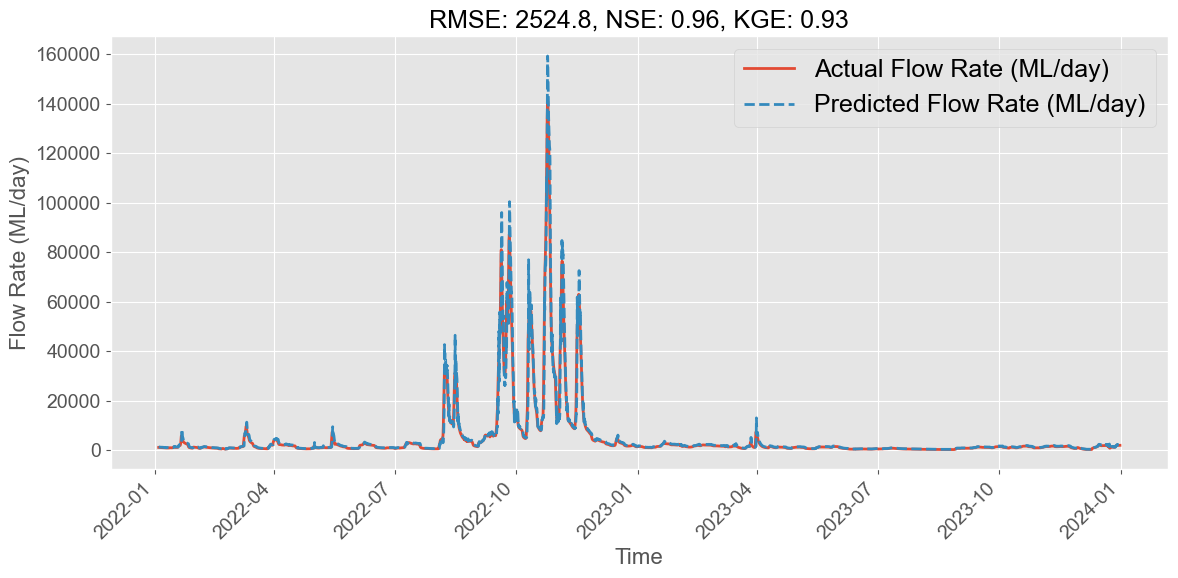

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

# Make sure you have already defined:
#   load_data
#   create_sequences
#   build_lstm_model
#   forecast
#   preprocess_data_inference (as above)

if __name__ == "__main__":
    # --- Parameters ---
    file_path = 'test_412019.csv'
    window_size = 48
    lead_time = 16

    # --- Load Model and scaler names (consistent naming) ---
    model_path = "lstm_flood_pro10_model2.h5"
    weights_path = model_path + "_best_val.weights.h5"
    scaler_path = model_path.replace('.h5', '_scaler.pkl')

    # --- 1. Load data ---
    df = load_data(file_path)

    # --- 2. Load the saved scaler ---
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"Cannot find scaler file: {scaler_path}")
    scaler = joblib.load(scaler_path)

    # --- 3. Preprocess new data (use inference version) ---
    X_new, Y_new_scaled, Y_new_unscaled, new_dates = preprocess_data_inference(
        df, scaler, column='Varibale Value', window_size=window_size, lead_time=lead_time
    )

    # --- 4. Build model architecture (must match trained model) ---
    model = build_lstm_model(window_size=window_size, lead_time=lead_time)

    # --- 5. Load trained weights ---
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Cannot find weights file: {weights_path}")
    model.load_weights(weights_path)

    # --- 6. Make predictions ---
    Y_new_predictions = forecast(model, X_new, scaler)

    # --- 7. Print first 10 pairs of actual vs predicted values ---
    plot_results(Y_new_unscaled, Y_new_predictions, new_dates)